# Linear Regression Forecasting

A popular forecasting tool is based on multiple linear regression models, which use predictors to capture trend and/or seasonality.  The model (mathematical equation) that results from the regression calculations can be used to produce future forecasts by inserting the relevant predictor information into the regression equation.  We will focus on linear regression.

This notebook was written using version 3.7.3 of Python.

### Importing the Necessary Packages

The first step in working with time series data is loading the necessary software packages.

In [1]:
# Import the data handling packages
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
# Import the visualization packages
import matplotlib.pyplot as plt

# Ensure the visualizations will work within this notebook
%matplotlib inline

In [3]:
# Import the statistical models packages
import math
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

In [4]:
# Import a warnings package to ignore/suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Loading and Preparing the Data

In this notebook, we will be working through an example to predict the number of passengers that will take a train.  The data for this example is provided in the Amtrak.csv file provided on Canvas.  First, we will load this data.  Then, we will prepare the data by taking the time series information and create a datetime index.

In [5]:
# Load the data into an object called Amtrak_df
Amtrak_df = pd.read_csv('Amtrak.csv')

# View the first several rows of the DataFrame
Amtrak_df.head()

,Month,Ridership
0,01/01/1991,1708.917
1,01/02/1991,1620.586
2,01/03/1991,1972.715
3,01/04/1991,1811.665
4,01/05/1991,1974.964


In [6]:
# Create a new column called Date that is the datetime format for the Month column
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df["Month"], format='%d/%m/%Y')

# View the first several rows of the DataFrame
Amtrak_df.head()

,Month,Ridership,Date
0,01/01/1991,1708.917,1991-01-01
1,01/02/1991,1620.586,1991-02-01
2,01/03/1991,1972.715,1991-03-01
3,01/04/1991,1811.665,1991-04-01
4,01/05/1991,1974.964,1991-05-01


In [7]:
# Create a Series data object that inludes the Ridership values and the datetime object as the index
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date, name='Ridership')
ridership_ts.index = pd.DatetimeIndex(ridership_ts.index, freq=ridership_ts.index.inferred_freq)

In [8]:
# View the first several rows of the ridership_ts Series
ridership_ts.head()

Date
1991-01-01    1708.917
1991-02-01    1620.586
1991-03-01    1972.715
1991-04-01    1811.665
1991-05-01    1974.964
Freq: MS, Name: Ridership, dtype: float64

### Creating a Linear Trend Regression Model

To create a linear regression model that captures a time series with a global linear trend, the outcome variable (Y) is set as the time series values (or some function of it), and the predictor (X) is set as the time index.  In our example, the output variable is the number of riders.  We will create a new variable that is a time index (1, 2, 3, etc.)  This time index will serve as a single predictor variable in our model.

Our first step is to fit a linear trend model to the dataset using the **tsatools.add_trend** and **sm.ols** methods.  Then, we will split the dataset into a training and validation dataset.  Finally, we will fit the training dataset to a linear regression model and predict the values for the validation dataset.

In [9]:
# Fit a linear trend model to the ridership_ts Series object
# Add the constant (const) column and the trend column (trend="ct")
ridership_df = tsatools.add_trend(ridership_ts, trend='ct')
ridership_lm = sm.ols(formula='Ridership ~ trend', data=ridership_df).fit()

In [10]:
# View the first several rows of the ridership_df DataFrame that includes the constant and trend information
ridership_df.head()

,Ridership,const,trend
Date,,,
1991-01-01,1708.917,1.0,1.0
1991-02-01,1620.586,1.0,2.0
1991-03-01,1972.715,1.0,3.0
1991-04-01,1811.665,1.0,4.0
1991-05-01,1974.964,1.0,5.0


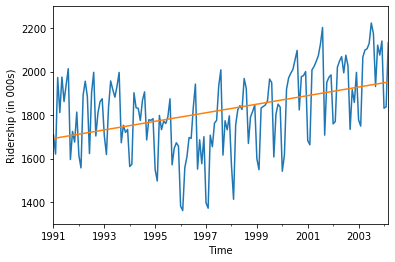

In [11]:
# Display the linear trend line with the data in the original dataset
ax = ridership_ts.plot()
ridership_lm.predict(ridership_df).plot(ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Ridership (in 000s)')
ax.set_ylim(1300, 2300)
plt.show()

In [12]:
# Partition the original dataset into a training dataset and a validation dataset
# Include 36 records in the validation dataset; the remainder should be used in the training dataset
nTrain = len(ridership_ts) - 36

# Create the training dataset
train_df = ridership_df[:nTrain]

# Create the validation dataset
valid_df = ridership_df[nTrain:]

In [13]:
# Fit linear model using training set and predict on validation set
ridership_lm = sm.ols(formula='Ridership ~ trend', data=train_df).fit()
predict_df = ridership_lm.predict(valid_df)

### Visualizing the Linear Trend Regression Model

Once the linear regression model is created, one of the easiest ways to review the predictions from this model is to graph them.  Below is code that can be used to graph these predictions and the forecast errors (known as residuals).

NOTE:  I don't expect that you can read and/or write this type of code.  This is provided here for you to reuse as you work on regression forecasting.

In [15]:
def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1990', '2004-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Time')
    one_month = pd.Timedelta('31 days')
    xtrain = (min(train_df.index), max(train_df.index) - one_month)
    xvalid = (min(valid_df.index) + one_month, max(valid_df.index) - one_month)
    xtv = xtrain[1] + 0.5 * (xvalid[0] - xtrain[1])

    ypos = 0.9 * ylim[1] + 0.1 * ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)

    ypos = 0.925 * ylim[1] + 0.075 * ylim[0]
    ax.text('1995', ypos, 'Training')
    ax.text('2002-3', ypos, 'Validation')

In [16]:
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [1300, 2550], train_df, valid_df)
    singleGraphLayout(axes[1], [-550, 550], train_df, valid_df)
    train_df.plot(y='Ridership', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='Ridership', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Ridership (in 000s)')
    axes[1].set_ylabel('Forecast Errors')
    if axes[0].get_legend(): 
        axes[0].get_legend().remove()

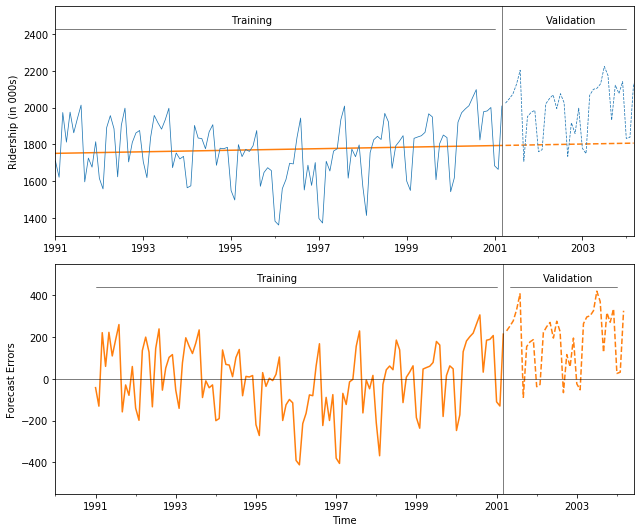

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
ridership_lm.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)

plt.tight_layout()
plt.show()

### Creating a Model with Seasonality

A seasonal pattern in a time series means that period that fall in some seasons have consistently higher or lower values than those that fall in other seasons.  Seasonality is captured in a regression model by creating a new variable that denotes the season for each value.  This variable is then turned into "dummy" variables that act as predictors for the model.

For our example, we will create a new Month column for the riders dataset.  This column will then be used to create 11 dummy variables (one for each month - 1).  If the data point is for that month, a 1 will be placed in the dummy variable column for that month; if not, the a 0 will be placed in the dummy variable for that month.

In [18]:
# Create a DataFrame that includes the constant
ridership_df = tsatools.add_trend(ridership_ts, trend='c')

# Create a Month column within the DataFrame that is the month from the datetime index
ridership_df['Month'] = ridership_df.index.month

# View the first several rows of the DataFrame
ridership_df.head()

,Ridership,const,Month
Date,,,
1991-01-01,1708.917,1.0,1
1991-02-01,1620.586,1.0,2
1991-03-01,1972.715,1.0,3
1991-04-01,1811.665,1.0,4
1991-05-01,1974.964,1.0,5


In [19]:
# Create the training dataset
train_df = ridership_df[:nTrain]

# Create the validation dataset
valid_df = ridership_df[nTrain:]

In [20]:
# Fit linear model using training dataset
ridership_lm_season = sm.ols(formula='Ridership ~ C(Month)', data=train_df).fit()

### Visualizing the Linear Regression Model with Seasonality

Once the linear regression model is created, one of the easiest ways to review the predictions from this model is to graph them.  Below is code that can be used to graph these predictions and the forecast errors (known as residuals).

NOTE:  I don't expect that you can read and/or write this type of code.  This is provided here for you to reuse as you work on regression forecasting.

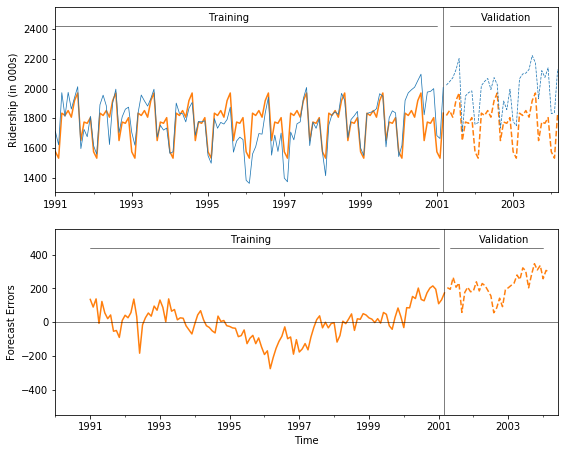

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))

ridership_lm_season.predict(train_df).plot(ax=axes[0], color='C1')
ridership_lm_season.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')
    
residual = train_df.Ridership - ridership_lm_season.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.Ridership - ridership_lm_season.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')

graphLayout(axes, train_df, valid_df)

plt.show()

# References
> (c) 2019 Yves Hilpisch. Code included in _Python for Finance: Mastering Data-driven Finance_ (Second Edition). Yves Hilpisch. 2019.
>
> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck.  Code included in _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition). Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.